In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import scipy
from skimage import color, exposure, measure, morphology, util
from segmentflow import segment, view
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Run Segmentflow on the sample IDOX_EstaneNP

Loading images...
--> Images loaded as 3D array:  (1012, 630, 630)
Plotting images: [100, 450, 800]


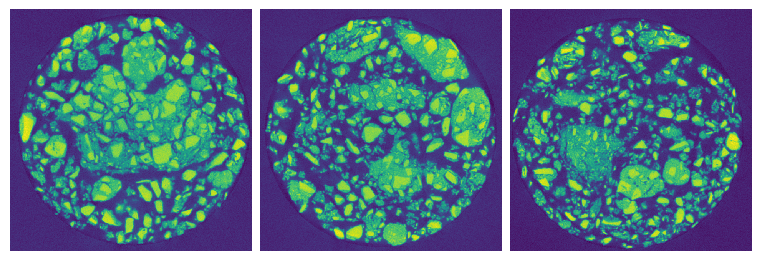

In [6]:
#-------------#
# Load images #
#-------------#
# row & col crop deterined in NB 14
slices = [100, 450, 800]
imgs = segment.load_images(
    r'../data/IDOX_EstaneNP/IDOX_EstaneNP_AHE',
    slice_crop=None,
    row_crop=[200, 830],
    col_crop=[190, 820],
    convert_to_float=True,
    file_suffix='.tiff'
)
fig, axes = view.plot_imgs(
    imgs,
    # n_imgs=3,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

## Investigate raw data

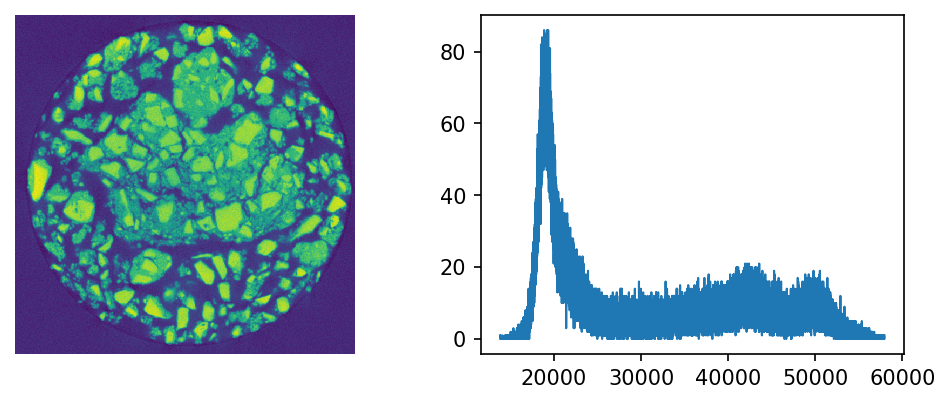

In [7]:
img = imgs[100, ...]
# Plot histogram
hist, hist_centers = exposure.histogram(img)
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=150)
ax = axes.ravel()
ax[0].imshow(img, interpolation='nearest')
ax[0].axis('off')
ax[1].plot(hist_centers, hist, lw=1)
plt.show()

## Apply median filter

Preprocessing images...
--> Applying median filter...
--> Preprocessing complete
Plotting images: [100, 450, 800]


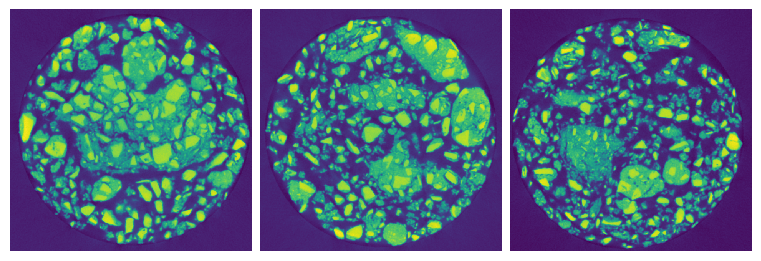

In [8]:
#---------------#
# Median filter #
#---------------#
imgs_med = segment.preprocess(
    imgs, median_filter=True,
    rescale_intensity_range=None
)
fig, axes = view.plot_imgs(
    imgs_med,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)


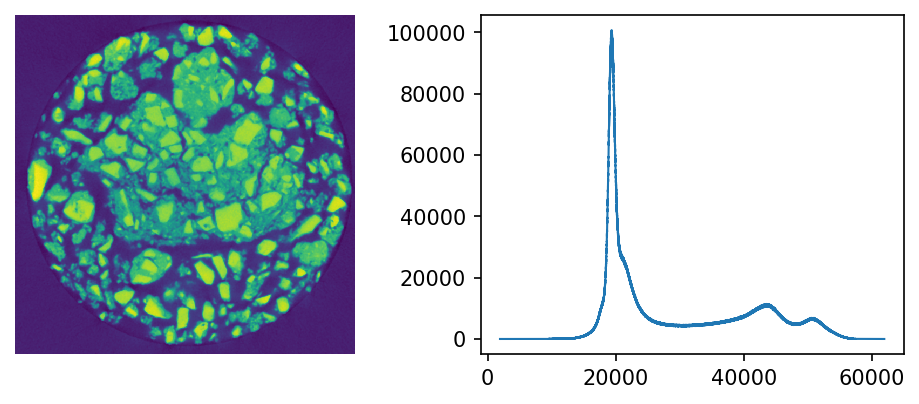

In [9]:
img = imgs_med[100, ...]
# Plot histogram
hist, hist_centers = exposure.histogram(imgs_med)
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=150)
ax = axes.ravel()
ax[0].imshow(img, interpolation='nearest')
ax[0].axis('off')
ax[1].plot(hist_centers, hist, lw=1)
plt.show()

## Find maxima

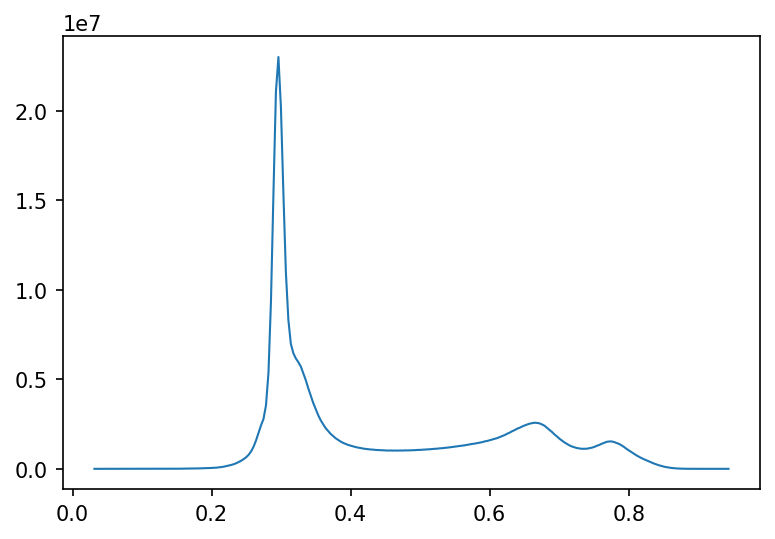

In [14]:
imgs_med_float = util.img_as_float(imgs_med)
# Plot histogram
hist, hist_centers = exposure.histogram(imgs_med_float, nbins=256)
fig, ax = plt.subplots(dpi=150)
ax.plot(hist_centers, hist, lw=1)
plt.show()

peaks.shape=(14,)
peaks=array([  4,   6,  12,  24,  74, 116, 119, 121, 123, 125, 177, 208, 247,
       251], dtype=int64)


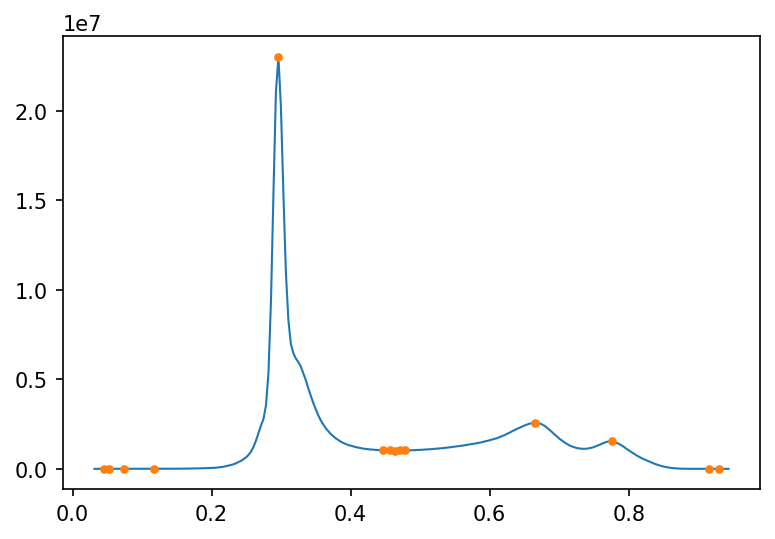

In [25]:
peaks, peak_props = scipy.signal.find_peaks(hist)
print(f'{peaks.shape=}')
print(f'{peaks=}')
fig, ax = plt.subplots(dpi=150)
ax.plot(hist_centers, hist, lw=1, zorder=0)
for i in peaks:
    ax.scatter(hist_centers[i], hist[i], s=10, c='C1', zorder=1)
plt.show()

peaks.shape=(3,)
peaks=array([ 74, 177, 207], dtype=int64)


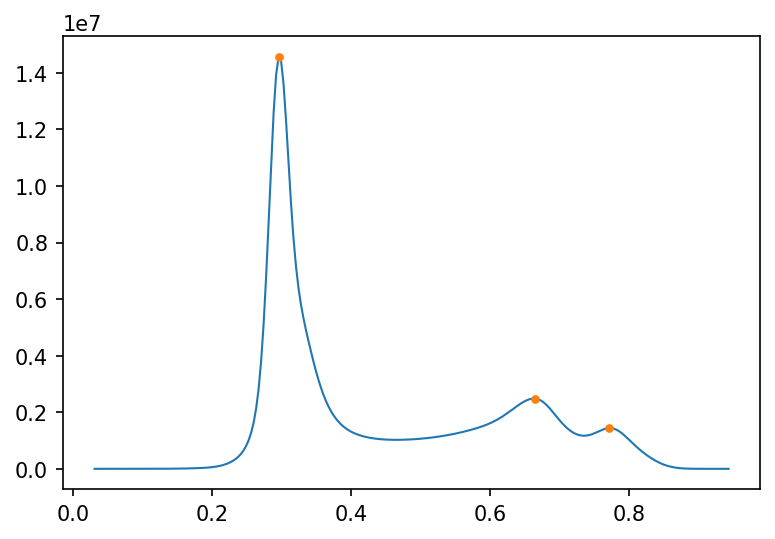

In [26]:
hist_smooth = scipy.ndimage.gaussian_filter(hist, 3)
peaks, peak_props = scipy.signal.find_peaks(hist_smooth)
print(f'{peaks.shape=}')
print(f'{peaks=}')
fig, ax = plt.subplots(dpi=150)
ax.plot(hist_centers, hist_smooth, lw=1, zorder=0)
for i in peaks:
    ax.scatter(hist_centers[i], hist_smooth[i], s=10, c='C1', zorder=1)
plt.show()

## Find minima between maxima

[0.4642268325131609, 0.7361097004463264]


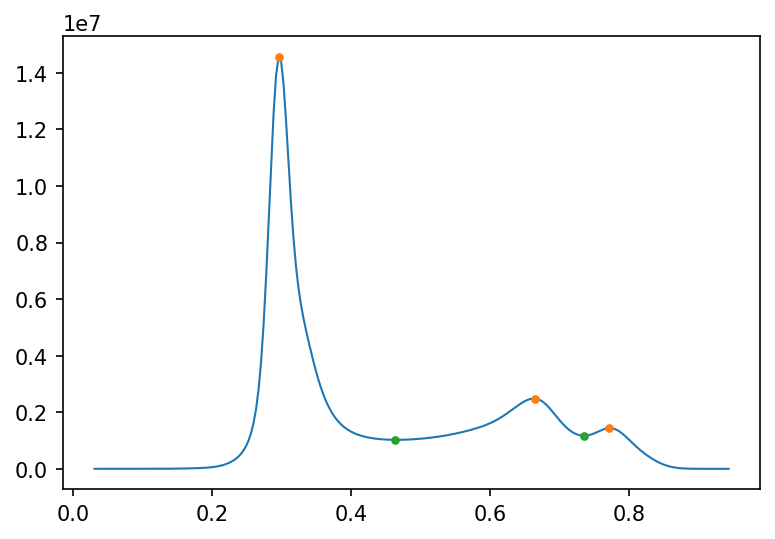

In [37]:
mins = []
for i in range(1, len(peaks)):
    min_sub_i = np.argmin(hist_smooth[peaks[i - 1] : peaks[i]])
    mins.append(min_sub_i + peaks[i - 1])
print([hist_centers[i] for i in mins])
fig, ax = plt.subplots(dpi=150)
ax.plot(hist_centers, hist_smooth, lw=1, zorder=0)
for i in peaks:
    ax.scatter(hist_centers[i], hist_smooth[i], s=10, c='C1', zorder=1)
for i in mins:
    ax.scatter(hist_centers[i], hist_smooth[i], s=10, c='C2', zorder=1)
plt.show()

## Minima function

In [41]:
def multi_min_threshold(imgs, nbins=256, **kwargs):
    print('Calculating thresholds from local minima...')
    if imgs.dtype != float:
        imgs = util.img_as_float32(imgs)
    hist, hist_centers = exposure.histogram(imgs, nbins=nbins)
    hist_smooth = scipy.ndimage.gaussian_filter(hist, 3)
    peaks, peak_props = scipy.signal.find_peaks(hist_smooth, **kwargs)
    print(f'--> {len(peaks)} peak(s) found: {peaks}')
    mins = []
    for i in range(1, len(peaks)):
        min_sub_i = np.argmin(hist_smooth[peaks[i - 1] : peaks[i]])
        mins.append(min_sub_i + peaks[i - 1])
    if imgs.dtype != float:
        # If image wasn't float, convert to 16-bit
        mins = [int(hist_centers[i] * 65536) for i in mins]
    else:
        mins = [hist_centers[i] for i in mins]
    print(f'--> {len(mins)} minima found: {mins}')
    return mins

thresh_vals = multi_min_threshold(imgs_med)

Calculating thresholds from local minima...
--> 3 peak(s) found: [ 74 177 207]
--> 2 minima found: [30423, 48241]


# Use thresholds to segment

Calculating thresholds from local minima...
--> 3 peak(s) found: [ 74 177 207]
--> 2 minima found: [30423, 48241]
Plotting images: [100, 450, 800]


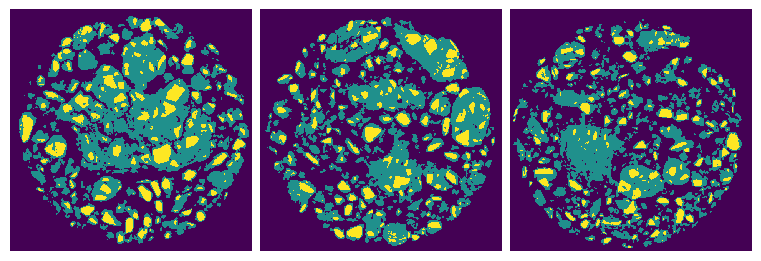

In [43]:
thresh_vals = segment.multi_min_threshold(imgs_med)
# Plot isolated classes
imgs_thresh = segment.isolate_classes(imgs_med, thresh_vals)
fig, axes = view.plot_imgs(
    imgs_thresh,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)
plt.show()